# 라이브러리 로딩


In [1]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from imblearn.combine import SMOTETomek

import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['axes.unicode_minus'] = False


# 시드 고정


In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)


seed = 42
seed_everything(seed)


# 데이터 불러오기


In [3]:
# 데이터 불러오기 및 분석에 도움이 되지 않는 ID 컬럼 제거
train = pd.read_csv('../dataset/train.csv').drop('ID', axis=1)
test = pd.read_csv('../dataset/test.csv').drop('ID', axis=1)

x_train = train.drop('전화해지여부', axis=1)
y_train = train['전화해지여부']


# 이상치 제거(IQR Capping)


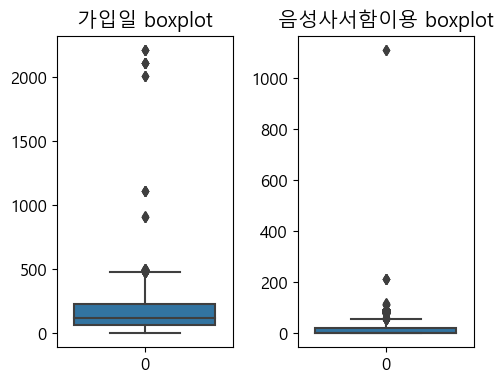

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(5, 4))
sns.boxplot(x_train['가입일'], ax=ax[0])
ax[0].set_title('가입일 boxplot')
sns.boxplot(x_train['음성사서함이용'], ax=ax[1])
ax[1].set_title('음성사서함이용 boxplot')
plt.tight_layout()
plt.show()


In [5]:
# 이상치 제거(IQR Capping)
q1_1 = x_train['가입일'].quantile(.25)
q3_1 = x_train['가입일'].quantile(.75)
iqr_1 = q3_1 - q1_1

q1_2 = x_train['음성사서함이용'].quantile(.25)
q3_2 = x_train['음성사서함이용'].quantile(.75)
iqr_2 = q3_2 - q1_2

maximum_1 = q3_1 + (iqr_1 * 1.5)
maximum_2 = q3_2 + (iqr_2 * 1.5)

x_train.loc[x_train['가입일'] > maximum_1, '가입일'] = maximum_1
x_train.loc[x_train['음성사서함이용'] > maximum_2, '음성사서함이용'] = maximum_2


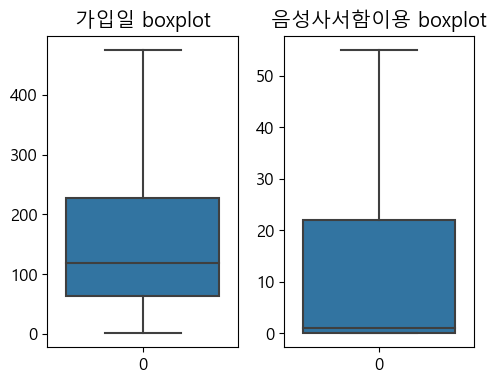

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(5, 4))
sns.boxplot(x_train['가입일'], ax=ax[0])
ax[0].set_title('가입일 boxplot')
sns.boxplot(x_train['음성사서함이용'], ax=ax[1])
ax[1].set_title('음성사서함이용 boxplot')
plt.tight_layout()
plt.show()


# 정규화(MinMaxScaler)


In [7]:
minmax = MinMaxScaler()

x_train = pd.DataFrame(minmax.fit_transform(x_train), columns=x_train.columns)

# 모델의 성능을 측정하기 위해서 검증 데이터 셋과 분리
train_x, val_x, train_y, val_y = train_test_split(
    x_train, y_train, test_size=.3, random_state=seed, stratify=y_train)


In [10]:
test = pd.DataFrame(minmax.transform(test), columns=test.columns)


# 오버샘플링 & 다운샘플링


In [12]:
sm = SMOTETomek(random_state=seed)

train_x_ov, train_y_ov = sm.fit_resample(train_x, train_y)

print('SMOTETomek 적용 전 학습용 피처/레이블 : ', train_x.shape, train_y.shape)
print('SMOTETomek 적용 후 학습용 피처/레이블 : ', train_x_ov.shape, train_y_ov.shape)
print()
print('SMOTETomek 적용 전 레이블 값 분포 :\n', pd.Series(train_y).value_counts())
print()
print('SMOTETomek 적용 후 레이블 값 분포 :\n', pd.Series(train_y_ov).value_counts())


SMOTETomek 적용 전 학습용 피처/레이블 :  (21140, 12) (21140,)
SMOTETomek 적용 후 학습용 피처/레이블 :  (37296, 12) (37296,)

SMOTETomek 적용 전 레이블 값 분포 :
 0    18817
1     2323
Name: 전화해지여부, dtype: int64

SMOTETomek 적용 후 레이블 값 분포 :
 0    18648
1    18648
Name: 전화해지여부, dtype: int64


In [173]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=seed)

train_x_ov, train_y_ov = adasyn.fit_resample(train_x, train_y)

print('ADASYN 적용 전 학습용 피처/레이블 : ', train_x.shape, train_y.shape)
print('ADASYN 적용 후 학습용 피처/레이블 : ', train_x_ov.shape, train_y_ov.shape)
print()
print('ADASYN 적용 전 레이블 값 분포 :\n', pd.Series(train_y).value_counts())
print()
print('ADASYN 적용 후 레이블 값 분포 :\n', pd.Series(train_y_ov).value_counts())

ADASYN 적용 전 학습용 피처/레이블 :  (21140, 12) (21140,)
ADASYN 적용 후 학습용 피처/레이블 :  (37177, 12) (37177,)

ADASYN 적용 전 레이블 값 분포 :
 0    18817
1     2323
Name: 전화해지여부, dtype: int64

ADASYN 적용 후 레이블 값 분포 :
 0    18817
1    18360
Name: 전화해지여부, dtype: int64


# 머신러닝 모델링


In [246]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.metrics import f1_score


In [248]:
rfc = RandomForestClassifier(min_samples_split=10, min_samples_leaf=10, max_depth=None, max_features='auto',
                             n_estimators=300, class_weight='balanced', criterion='entropy', random_state=seed)

lgbm = LGBMClassifier(boosting_type='gbdt', class_weight=None, is_unbalance=True, learning_rate=.1,
                      max_depth=-1, n_estimators=500, scale_pos_weight=1, objective='binary', random_state=seed)

xgb = XGBClassifier(booster='gbtree', learning_rate=.1, max_depth=9,
                    n_estimators=200, scale_pos_weight=8.1, random_state=seed, objective='binary:logistic' ,eval_metric='auc')


In [249]:
# rfc.fit(train_x_ov,train_y_ov)
rfc.fit(train_x, train_y)

# lgbm.fit(train_x_ov,train_y_ov)
lgbm.fit(train_x, train_y)

# xgb.fit(train_x_ov, train_y_ov)
xgb.fit(train_x, train_y)


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [250]:
print('RandomForest : ', f1_score(train_y, rfc.predict(train_x), average='macro'))
print('LGBM : ', f1_score(train_y, lgbm.predict(train_x), average='macro'))
print('XGB : ', f1_score(train_y, xgb.predict(train_x), average='macro'))


RandomForest :  0.9361122480738413
LGBM :  0.9455998708116558
XGB :  0.9668500250206765


In [251]:
print('RandomForest : ', f1_score(val_y, rfc.predict(val_x), average='macro'))
print('LGBM : ', f1_score(val_y, lgbm.predict(val_x), average='macro'))
print('XGB : ', f1_score(val_y, xgb.predict(val_x), average='macro'))


RandomForest :  0.7669190269134848
LGBM :  0.798240582309111
XGB :  0.8031739824681461


In [252]:
vot = VotingClassifier(estimators=[('rfc', rfc), ('lgbm', lgbm), ('xgb', xgb)], weights=[
                       1, 1.03, 1.05], voting='hard')

vot.fit(train_x, train_y)


VotingClassifier(estimators=[('rfc',
                              RandomForestClassifier(class_weight='balanced',
                                                     criterion='entropy',
                                                     max_features='auto',
                                                     min_samples_leaf=10,
                                                     min_samples_split=10,
                                                     n_estimators=300,
                                                     random_state=42)),
                             ('lgbm',
                              LGBMClassifier(is_unbalance=True,
                                             n_estimators=500,
                                             objective='binary',
                                             random_state=42,
                                             scale_pos_weight=1)),
                             ('xgb',
                              XGBClassifier(base_score=None,...
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=9,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=42, ...))],
                 weights=[1, 1.03, 1.05])

In [253]:
print(classification_report(train_y, vot.predict(train_x)))
print(classification_report(val_y, vot.predict(val_x)))
print('Voting : ', f1_score(train_y, vot.predict(train_x), average='macro'))
print('Voting : ', f1_score(val_y, vot.predict(val_x), average='macro'))


              precision    recall  f1-score   support

           0       1.00      0.98      0.99     18817
           1       0.86      1.00      0.92      2323

    accuracy                           0.98     21140
   macro avg       0.93      0.99      0.96     21140
weighted avg       0.98      0.98      0.98     21140

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      8065
           1       0.69      0.62      0.65       995

    accuracy                           0.93      9060
   macro avg       0.82      0.79      0.80      9060
weighted avg       0.92      0.93      0.93      9060

Voting :  0.9559379060169685
Voting :  0.804881652479722


In [254]:
stack = StackingClassifier(estimators=[('rfc',rfc),('lgbm',lgbm),('xgb',xgb)], final_estimator=vot, stack_method='predict')

stack.fit(train_x, train_y)

StackingClassifier(estimators=[('rfc',
                                RandomForestClassifier(class_weight='balanced',
                                                       criterion='entropy',
                                                       max_features='auto',
                                                       min_samples_leaf=10,
                                                       min_samples_split=10,
                                                       n_estimators=300,
                                                       random_state=42)),
                               ('lgbm',
                                LGBMClassifier(is_unbalance=True,
                                               n_estimators=500,
                                               objective='binary',
                                               random_state=42,
                                               scale_pos_weight=1)),
                               ('xgb',
                                XGBClassifier(base_score=Non...
                                                                               interaction_constraints=None,
                                                                               learning_rate=0.1,
                                                                               max_bin=None,
                                                                               max_cat_threshold=None,
                                                                               max_cat_to_onehot=None,
                                                                               max_delta_step=None,
                                                                               max_depth=9,
                                                                               max_leaves=None,
                                                                               min_child_weight=None,
                                                                               missing=nan,
                                                                               monotone_constraints=None,
                                                                               n_estimators=200,
                                                                               n_jobs=None,
                                                                               num_parallel_tree=None,
                                                                               predictor=None,
                                                                               random_state=42, ...))],
                                                    weights=[1, 1.03, 1.05]),
                   stack_method='predict')

In [255]:
print(classification_report(train_y, stack.predict(train_x)))
print(classification_report(val_y, stack.predict(val_x)))
print('stacking : ', f1_score(train_y, stack.predict(train_x), average='macro'))
print('stacking : ', f1_score(val_y, stack.predict(val_x), average='macro'))


              precision    recall  f1-score   support

           0       1.00      0.96      0.98     18817
           1       0.77      1.00      0.87      2323

    accuracy                           0.97     21140
   macro avg       0.89      0.98      0.93     21140
weighted avg       0.98      0.97      0.97     21140

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      8065
           1       0.58      0.72      0.64       995

    accuracy                           0.91      9060
   macro avg       0.77      0.83      0.80      9060
weighted avg       0.92      0.91      0.92      9060

stacking :  0.9273445248055631
stacking :  0.7965582474894981


In [245]:
pred_xgb = xgb.predict(test)
pred_vot = vot.predict(test)
pred_stack = stack.predict(test)

submit = pd.read_csv('../dataset/sample_submission.csv')
submit['전화해지여부'] = pred_xgb
submit.to_csv('./xgb.csv', index=False)
submit['전화해지여부'] = pred_vot
submit.to_csv('./vot.csv', index=False)
submit['전화해지여부'] = pred_stack
submit.to_csv('./stack.csv', index=False)